In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-uvvs57r4
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-uvvs57r4
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=41d4072847eb20b6770e0c63737abc607af0ca6f928bd30f4926f11450db1bec
  Stored in directory: /tmp/pip-ephem-wheel-cache-mjfrefmv/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
!pip install tf2crf

In [5]:
## importing necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 

## building model 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
# from keras_contrib.layers import CRF 
from tf2crf import CRF, ModelWithCRFLoss
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
# Hyperparams if GPU is available
if tf.config.list_physical_devices('GPU'):
  print("GPU is Available")
  BATCH_SIZE = 512  # Number of examples used in each iteration
  EPOCHS = 5  # Number of passes through entire dataset
  MAX_LEN = 75  # Max length of review (in words)
  EMBEDDING = 40  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
  print("GPU is not activated")
  BATCH_SIZE = 32
  EPOCHS = 5
  MAX_LEN = 75
  EMBEDDING = 20

GPU is Available


In [7]:
cd "/content/drive/MyDrive/NER Project"

/content/drive/MyDrive/NER Project


In [8]:
## reading ner dataset
ner_data = pd.read_csv('Dataset/ner_dataset.csv', encoding='latin1')

## size or shape of the dataset
print(f"Shape/size of NER dataset :- \n {ner_data.shape}")

Shape/size of NER dataset :- 
 (1048575, 4)


In [9]:
print(f"Top 5 rows from dataset :- \n {ner_data.head(20)}")

Top 5 rows from dataset :- 
      Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1           NaN             of   IN      O
2           NaN  demonstrators  NNS      O
3           NaN           have  VBP      O
4           NaN        marched  VBN      O
5           NaN        through   IN      O
6           NaN         London  NNP  B-geo
7           NaN             to   TO      O
8           NaN        protest   VB      O
9           NaN            the   DT      O
10          NaN            war   NN      O
11          NaN             in   IN      O
12          NaN           Iraq  NNP  B-geo
13          NaN            and   CC      O
14          NaN         demand   VB      O
15          NaN            the   DT      O
16          NaN     withdrawal   NN      O
17          NaN             of   IN      O
18          NaN        British   JJ  B-gpe
19          NaN         troops  NNS      O


In [10]:
## check is these any nan values 
print(f"Is there any null values in the NER dataset \n {ner_data.isnull().sum()}")

Is there any null values in the NER dataset 
 Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [11]:
ner_data = ner_data.fillna(method="ffill")

In [12]:
ner_data = ner_data.drop('POS', axis=1)

In [13]:
ner_data

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


In [14]:
class SentenceGetter(object):
  """Class to Get the sentence in this format:
  [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
  def __init__(self, data):
    """Args:
    data is the pandas.DataFrame which contains the above dataset"""
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                       s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]
    
  def get_next(self):
    """Return one sentence"""
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None
        
getter = SentenceGetter(ner_data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [15]:
## get all sentencees
sentences = getter.sentences

In [16]:
print(f"Max length sentence length :- {max([len(sent) for sent in sentences])}")

Max length sentence length :- 104


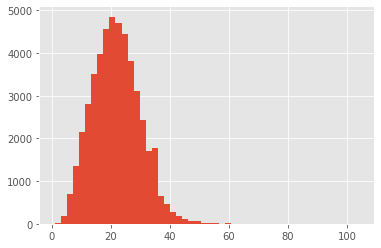

In [17]:
## plot histogram using sentences length
%matplotlib inline
plt.hist([len(sent) for sent in sentences], bins=50)
plt.show()

In [18]:
## unique words 
words = set(ner_data['Word'].values.tolist())
num_words = len(words)
print(f"Total number of unique words in NER data :- {num_words}")
## create a dictionary for word to index mapping 
word2index = {word:index+2 for index, word in enumerate(words)}
index2words = {index:word for index, word in word2index.items()}
word2index["UNK"] = 0
word2index["PAD"] = 1

Total number of unique words in NER data :- 35178


In [19]:
## unique tags
tags = set(ner_data['Tag'].values.tolist())
no_tags = len(tags)
print(f"Total number of unique tags in NER data :- {no_tags}")
## create a dictionary for tag to index mapping 
tag2index = {tag: index+1 for index, tag in enumerate(tags)}
tag2index['PAD'] = 0
index2tag = {index:tag for index, tag in tag2index.items()}

Total number of unique tags in NER data :- 17


In [20]:
## applying sequence padding on words
# word2index = {}
X = [[word2index[word[0]] for word in sent] for sent in sentences]
X = pad_sequences(maxlen = MAX_LEN, 
                  sequences = X , 
                  padding ='post',
                  value =word2index['PAD'])

## applying sequence padding on target
# tag2index = {}
y = [[tag2index[word[1]] for word in sent] for sent in sentences]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2index["PAD"])

## conveert target variable sequence to one hot encoding sequence

# y = [to_categorical(i, num_classes=no_tags+1) for i in y]  


In [21]:
## split the data into train and test data

## splitting padding sentences to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2018)

In [22]:
input_layer = Input(shape=(MAX_LEN))
embedding_layer = Embedding(input_dim = num_words+2, output_dim = EMBEDDING, input_length = MAX_LEN, mask_zero=True)(input_layer)
# embedding_layer = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_layer)
hidden_layer_1 = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.1, dropout=0.2))(embedding_layer)
hidden_layer_2 = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(hidden_layer_1)
# connect_hidden_layer_1_2 = add([hidden_layer_1, hidden_layer_2]) # residual connection to the first biLSTM
output_layer = TimeDistributed(Dense(no_tags, activation="relu"))(hidden_layer_2)
crf = CRF(dtype='float32')
output_layer = crf(output_layer)
base_model = Model(input_layer, output_layer)
model = ModelWithCRFLoss(base_model)
# final_output_layer = crf(output_layer)


In [23]:
model.compile(optimizer='adam')

In [24]:
type(X_train), type(y_train), len(X_train), len(y_train[0])

(numpy.ndarray, numpy.ndarray, 43163, 75)

In [25]:
y_train[1]

array([7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2,verbose = 1, mode ='max',restore_best_weights = True)
callbacks = early_stopping
# history = model.fit( X_train,np.array(y_train), validation_split = 0.1, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose =2,callbacks=callbacks)
history = model.fit(X_train, np.array(y_train), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/5
85/85 [==============================] - 166s 2s/step - crf_loss: 32.0137 - accuracy: 0.9019
Epoch 2/5
85/85 [==============================] - 150s 2s/step - crf_loss: 17.6019 - accuracy: 0.9538
Epoch 3/5
85/85 [==============================] - 152s 2s/step - crf_loss: 13.8650 - accuracy: 0.9544
Epoch 4/5
85/85 [==============================] - 152s 2s/step - crf_loss: 7.0887 - accuracy: 0.9685
Epoch 5/5
85/85 [==============================] - 151s 2s/step - crf_loss: -1.1887 - accuracy: 0.9786


In [27]:
model.evaluate(X_test, np.array(y_test))

150/150 [==============================] - 29s 187ms/step - crf_loss_val: -4.9328 - val_accuracy: 0.9797


[-0.0519888736307621, 0.9795385003089905]